# Financial Model
Using real web-scraped ROA, ROE, stock data and real ESG core metric scores  

## Import Libraries and Data

In [44]:
#!pip install supabase

In [2]:
import os
from supabase import create_client, Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [ ]:
# Connect to the database
# From supabase, get the url and key
url = ''
key = ''
supabase = create_client(url, key)

In [4]:
# Extract the data (Don't run this cell first, until the database is properly set up)
esg_rag_sql = (
    supabase.table("esg_rag_table")
    .select("*")
    .execute()
)

esg_rag = pd.DataFrame(esg_rag_sql.data)
companies = esg_rag["company"].unique()

stocks_sql = (
    supabase.table("stocks_table")
    .select("*")
    .eq("company", companies)
    .execute()
)

roa_roe_sql = (
    supabase.table("roa_roe_table")
    .select("*").in_("company", "DBS")
    .execute()
)

stocks = pd.DataFrame(stocks_sql.data)
roa_roe = pd.DataFrame(roa_roe_sql.data)

KeyError: 'company'

In [38]:
# Load datasets (Remove once database is properly setup)
roa_roe = pd.read_csv("roa_roe_table_rows.csv")
stocks = pd.read_csv("stocks_table_rows.csv")
esg_rag = pd.read_csv("esg_scores_2023.csv")

## Data Cleaning and Joining

In [39]:
# Format time-based columns
roa_roe["date"] = pd.to_datetime(roa_roe["date"], format="%d/%m/%Y")
roa_roe["year"] = roa_roe["date"].dt.year
stocks["date"] = pd.to_datetime(stocks["date"], format="%d/%m/%Y")
stocks["year"] = stocks["date"].dt.year
stocks["month"] = stocks["date"].dt.month

In [40]:
# Drop NaN values in financial ratios
roa_roe.dropna(subset=['roa', 'roe'], inplace=True)
stocks.dropna(subset=['close'], inplace=True)

# Replace out-of-range ESG values with NaN
esg_rag['final_score'] = esg_rag['final_score'].apply(lambda x: np.nan if x < 0 or x > 1 else x)

## Data Transformation
Transform stock price to stock percentage growth (annual linear return) to measure long term trends in stock performance

In [57]:
# Compute the first (Jan) and last (Dec) stock price for each company-year
prices_year_start = stocks[stocks['month'] == 1].set_index(['company', 'year'])[['close']].rename(columns={'close': 'beginning_price'}).sort_values(by=['company','year'])    
prices_year_end = stocks[stocks['month'] == 12].set_index(['company', 'year'])[['close']].rename(columns={'close': 'ending_price'}).sort_values(by=['company','year'])    

# Merge to get both beginning and ending stock prices
stocks_return = prices_year_start.join(prices_year_end).reset_index()

# Compute annual linear return
stocks_return['stock growth'] = (stocks_return['ending_price'] - stocks_return['beginning_price']) / stocks_return['beginning_price']

# Drop NA values
stocks_return.dropna(subset=['stock growth'], inplace=True)

stocks_return[stocks_return['company'] =='DBS']

,company,year,beginning_price,ending_price,stock growth
76,DBS,2016,8.228193,11.961740,0.453750
77,DBS,2017,11.810404,17.156364,0.452648
78,DBS,2018,18.651051,16.164873,-0.133300
79,DBS,2019,16.786604,18.125864,0.079781
80,DBS,2020,17.225639,18.901140,0.097268
81,DBS,2020,17.225639,18.901140,0.097268
82,DBS,2021,19.997076,27.312330,0.365816
83,DBS,2021,19.997076,27.312330,0.365816
84,DBS,2022,26.241564,28.982418,0.104447


Aggregate ESG metric scores to overall ESG score

In [63]:
#esg_cat_sql = (
#    supabase.table("esg_rag_table")
#    .select("topic")
#    .distinct()
#    .execute()
#)
#esg_cat = pd.DataFrame(esg_cat_sql.data)

# Define ESG category mappings (Use sql query once setup)
env_metrics = [
    "Total Greenhouse Gas Emissions",
    "Total Energy consumption",
    "Total Water Consumption",
    "Total Waste Generated"
]
social_metrics = [
    "Current Employees by Gender",
    "Employee Turnover rate by Gender",
    "New Hires by Gender",
    "Current Employees by Age Groups",
    "New employee hires by age group",
    "Total turnover rate",
    "Average Training Hours per Employee",
    "Fatalities",
    "High-consequence injuries",
    "Recordable injuries",
    "Number of Recordable Work-related Ill Health Cases"
]

governance_metrics = [
    "Board Independence",
    "Women on the Board",
    "Women in Management",
    "Anti-corruption disclosures",
    "Anti-Corruption Training for Employees",
    "Certification",
    "Alignment with frameworks and disclosure practices",
    "Assurance of sustainability report"
]

# Pivot the ESG data to a wide format
esg_wide = esg_rag.pivot_table(
    index=["company", "year"], 
    columns="topic", 
    values="final_score", 
    aggfunc="first"
).reset_index()

# Compute ESG component scores
esg_wide["environmental_score"] = esg_wide[env_metrics].mean(axis=1)
esg_wide["social_score"] = esg_wide[social_metrics].mean(axis=1)
esg_wide["governance_score"] = esg_wide[governance_metrics].mean(axis=1)

# Compute total ESG score
esg_wide["overall_esg_score"] = (
    esg_wide["environmental_score"] * 3.33 + 
    esg_wide["social_score"] * 3.33 + 
    esg_wide["governance_score"] * 3.33
)

# Merge with financial data (roa_roe)
df = roa_roe.merge(esg_wide[["company", "year", "environmental_score", "social_score", "governance_score", "overall_esg_score"]], on=["company", "year"], how="inner")
df = df.merge(stocks_return[["company", "year", "stock growth"]], on=["company", "year"])

# Save to CSV for review
df.to_csv("merged_financial_esg.csv", index=False)

print(df.head())  # Check output

  company       date      roa      roe  year  environmental_score  \
0    OCBC 2023-12-31  0.01460  0.13700  2023             0.579010   
1     UOB 2023-12-31  0.01068  0.12864  2023             0.256668   

   social_score  governance_score  overall_esg_score  stock growth  
0      0.473119          0.441580           4.974049      0.005414  
1      0.456484          0.452035           3.880073     -0.077497  


## Feature Importance using Recursive Feature Elimination
Select features (ESG metrics) that best predict ROA, ROE, stock prices  

Company-wide feature selection

In [75]:
esg_wide = esg_rag.pivot_table(
    index=["company", "year"], 
    columns="topic", 
    values="final_score", 
    aggfunc="first"
).reset_index()

df_features = roa_roe.merge(esg_wide, on=["company", "year"], how="inner")
df_features = df_features.merge(stocks_return[["company", "year", "stock growth"]], on=["company", "year"])

print(df_features)

  company       date      roa      roe  year  \
0    OCBC 2023-12-31  0.01460  0.13700  2023   
1     UOB 2023-12-31  0.01068  0.12864  2023   

   Alignment with frameworks and disclosure practices  \
0                                           0.041919    
1                                           0.548188    

   Anti-Corruption Training for Employees  Anti-corruption disclosures  \
0                                0.100419                     0.076111   
1                                0.992565                     0.426957   

   Assurance of sustainability report  Average Training Hours per Employee  \
0                            0.859630                             0.392647   
1                            0.205749                             0.614066   

   ...  Number of Recordable Work-related Ill Health Cases  \
0  ...                                           0.277263    
1  ...                                           0.012197    

   Recordable injuries  Total Energy c

In [78]:
esg_wide = esg_rag.pivot_table(
    index=["company", "year"], 
    columns="topic", 
    values="final_score", 
    aggfunc="first"
).reset_index()

df_features = roa_roe.merge(esg_wide, on=["company", "year"], how="inner")
df_features = df_features.merge(stocks_return[["company", "year", "stock growth"]], on=["company", "year"])

# Define features and targets
features = df_features.drop(columns=['roa', 'roe', 'stock growth', 'company', 'year', 'date', 'Certification'])
targets = ['roa', 'roe', 'stock growth']

top_features_rfe = {}

for target in targets:
    X = features
    y = df_features[target]

    # Fit an approximate linear model
    model = LinearRegression()
    rfe = RFE(model, n_features_to_select=5)  # Select top 5 features
    rfe.fit(X, y)

    # Get selected feature names
    selected_features = np.array(features.columns)[rfe.support_]
    top_features_rfe[target] = selected_features.tolist()

print("Top 5 features per target variable using RFE:")
print(top_features_rfe)


Top 5 features per target variable using RFE:
{'roa': ['Anti-Corruption Training for Employees', 'Assurance of sustainability report', 'Current Employees by Gender', 'Total Greenhouse Gas Emissions', 'Total turnover rate'], 'roe': ['Anti-Corruption Training for Employees', 'Assurance of sustainability report', 'Current Employees by Gender', 'Total Greenhouse Gas Emissions', 'Total turnover rate'], 'stock growth': ['Anti-Corruption Training for Employees', 'Assurance of sustainability report', 'Current Employees by Gender', 'Total Greenhouse Gas Emissions', 'Total turnover rate']}


In [79]:
from collections import Counter

# Combine the selected features from all targets into one list
all_selected_features = top_features_rfe['roa'] + top_features_rfe['roe'] + top_features_rfe['stock growth']

# Count the frequency of each feature
feature_counts = Counter(all_selected_features)

# Sort features by frequency and select the top 5
top_5_features = [feature for feature, count in feature_counts.most_common(5)]
print("Top 5 Features Across All Targets:", top_5_features)


Top 5 Features Across All Targets: ['Anti-Corruption Training for Employees', 'Assurance of sustainability report', 'Current Employees by Gender', 'Total Greenhouse Gas Emissions', 'Total turnover rate']


# Linear Regression

In [15]:
# Plotting the Relations

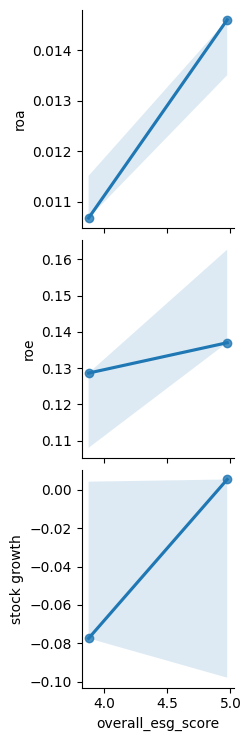

In [64]:
sns.pairplot(df, x_vars=["overall_esg_score"], y_vars=["roa", "roe", "stock growth"], kind="reg")
plt.show()

In [66]:
# Define independent variable
X = df["overall_esg_score"]
X = sm.add_constant(X)  # Add intercept

# Dependent variables
y_roa = df["roa"]
y_roe = df["roe"]
y_stock = df["stock growth"]

# Fit regression models
model_roa = sm.OLS(y_roa, X).fit()
model_roe = sm.OLS(y_roe, X).fit()
model_stock = sm.OLS(y_stock, X).fit()

# Print results
print(model_roa.summary())  # ROA model
print(model_roe.summary())  # ROE model
print(model_stock.summary())  # Stock model

                            OLS Regression Results                            
Dep. Variable:                    roa   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 26 Mar 2025   Prob (F-statistic):                nan
Time:                        18:34:33   Log-Likelihood:                 76.181
No. Observations:                   2   AIC:                            -148.4
Df Residuals:                       0   BIC:                            -151.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0032        in

C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmod

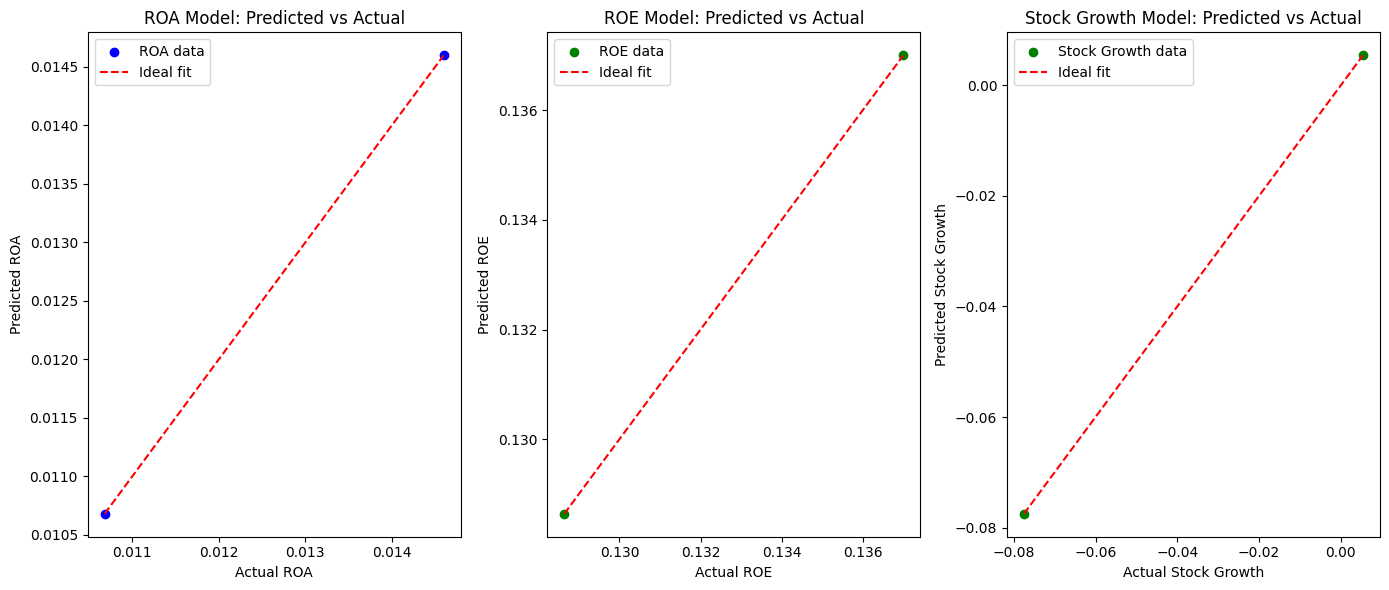

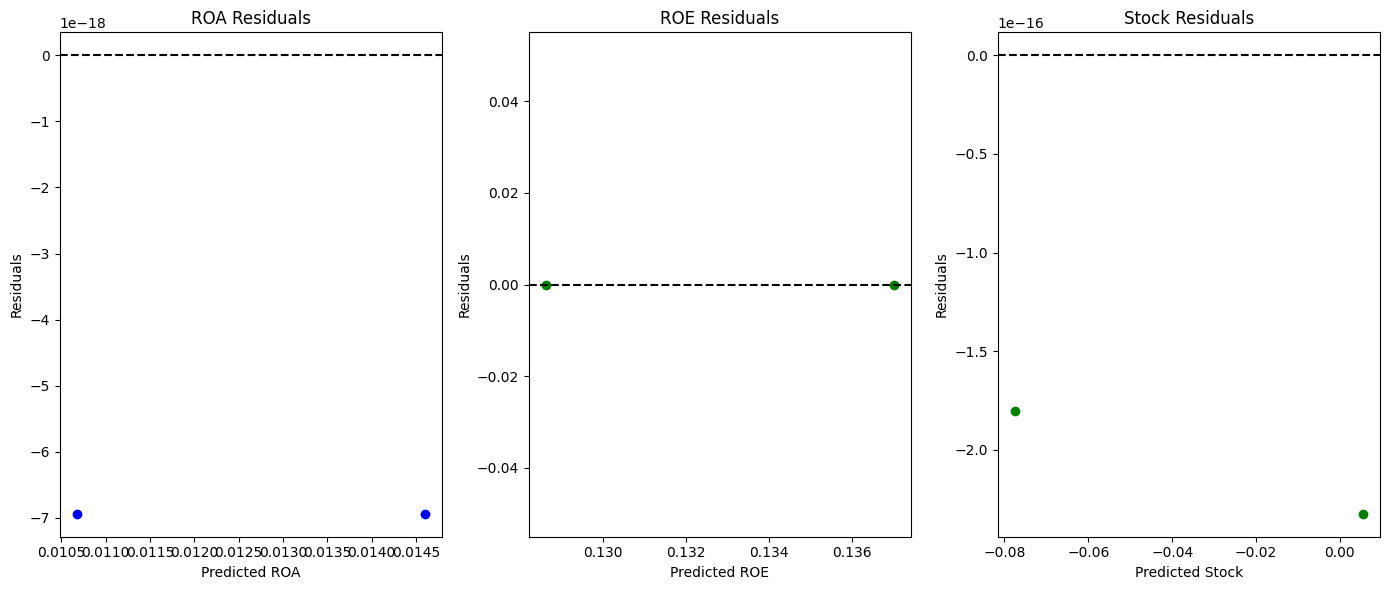

In [70]:
# ROA and ROE predictions
y_roa_pred = model_roa.predict(X)
y_roe_pred = model_roe.predict(X)
y_stock_pred = model_stock.predict(X)

# Set up the plot
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Plot ROA model
axes[0].scatter(y_roa, y_roa_pred, color='blue', label='ROA data')
axes[0].plot([min(y_roa), max(y_roa)], [min(y_roa), max(y_roa)], color='red', linestyle='--', label='Ideal fit')
axes[0].set_title('ROA Model: Predicted vs Actual')
axes[0].set_xlabel('Actual ROA')
axes[0].set_ylabel('Predicted ROA')
axes[0].legend()

# Plot ROE model
axes[1].scatter(y_roe, y_roe_pred, color='green', label='ROE data')
axes[1].plot([min(y_roe), max(y_roe)], [min(y_roe), max(y_roe)], color='red', linestyle='--', label='Ideal fit')
axes[1].set_title('ROE Model: Predicted vs Actual')
axes[1].set_xlabel('Actual ROE')
axes[1].set_ylabel('Predicted ROE')
axes[1].legend()


# Plot Stock Growth model
axes[2].scatter(y_stock, y_stock_pred, color='green', label='Stock Growth data')
axes[2].plot([min(y_stock), max(y_stock)], [min(y_stock), max(y_stock)], color='red', linestyle='--', label='Ideal fit')
axes[2].set_title('Stock Growth Model: Predicted vs Actual')
axes[2].set_xlabel('Actual Stock Growth')
axes[2].set_ylabel('Predicted Stock Growth')
axes[2].legend()

# Display plots
plt.tight_layout()
plt.show()

# Plot residuals for both models
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# ROA residuals
axes[0].scatter(y_roa_pred, model_roa.resid, color='blue')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_title('ROA Residuals')
axes[0].set_xlabel('Predicted ROA')
axes[0].set_ylabel('Residuals')

# ROE residuals
axes[1].scatter(y_roe_pred, model_roe.resid, color='green')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_title('ROE Residuals')
axes[1].set_xlabel('Predicted ROE')
axes[1].set_ylabel('Residuals')

# Stock residuals
axes[2].scatter(y_stock_pred, model_stock.resid, color='green')
axes[2].axhline(0, color='black', linestyle='--')
axes[2].set_title('Stock Residuals')
axes[2].set_xlabel('Predicted Stock')
axes[2].set_ylabel('Residuals')

# Display residual plots
plt.tight_layout()
plt.show()

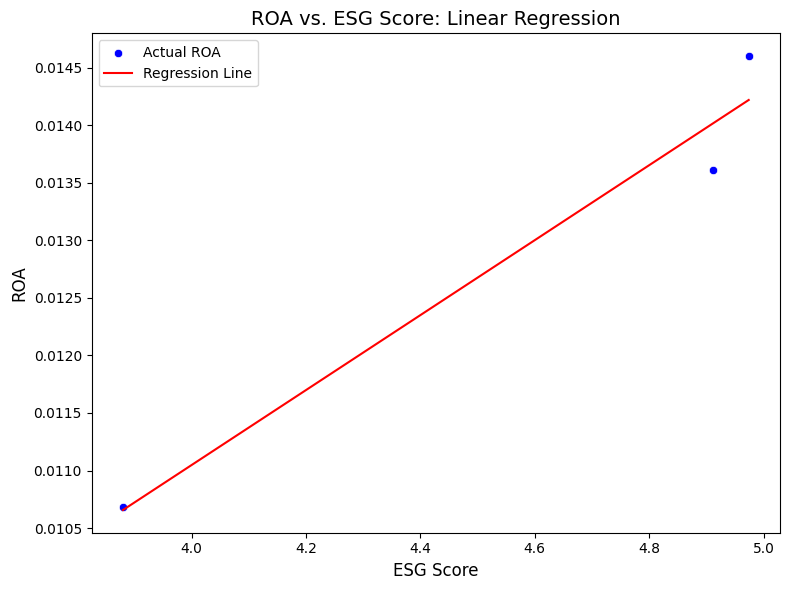

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_esg = X['overall_esg_score']

# Assuming 'X' is ESG score and 'y_roa' is ROA from your model
# Get the predicted ROA values from the model
y_roa_pred = model_roa.predict(X)

# Create a scatter plot of ESG score vs. actual ROA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_esg, y=y_roa, color='blue', label='Actual ROA')

# Plot the regression line (fit)
sns.lineplot(x=X_esg, y=y_roa_pred, color='red', label='Regression Line')

# Title and labels
plt.title('ROA vs. ESG Score: Linear Regression', fontsize=14)
plt.xlabel('ESG Score', fontsize=12)
plt.ylabel('ROA', fontsize=12)

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

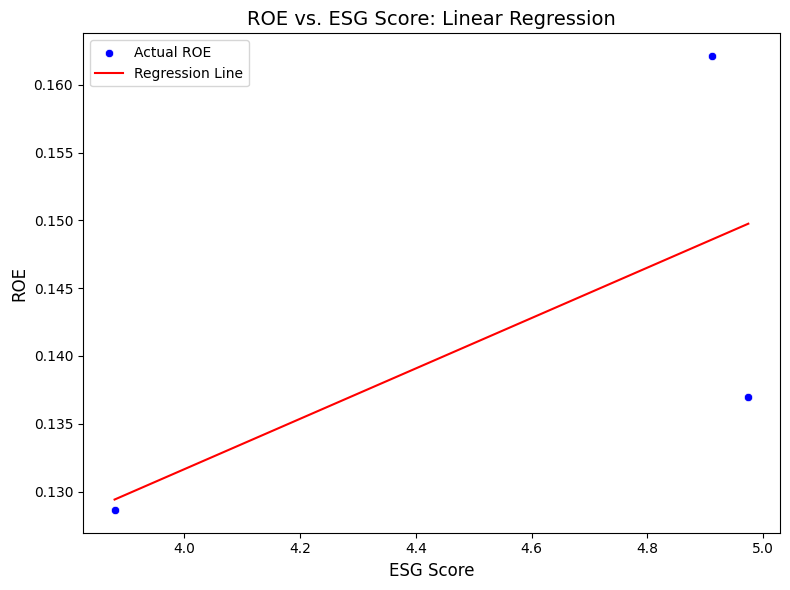

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_esg = X['overall_esg_score']

# Assuming 'X' is ESG score and 'y_roe' is ROE from your model
# Get the predicted ROE values from the model
y_roe_pred = model_roe.predict(X)

# Create a scatter plot of ESG score vs. actual ROE
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_esg, y=y_roe, color='blue', label='Actual ROE')

# Plot the regression line (fit)
sns.lineplot(x=X_esg, y=y_roe_pred, color='red', label='Regression Line')

# Title and labels
plt.title('ROE vs. ESG Score: Linear Regression', fontsize=14)
plt.xlabel('ESG Score', fontsize=12)
plt.ylabel('ROE', fontsize=12)

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()

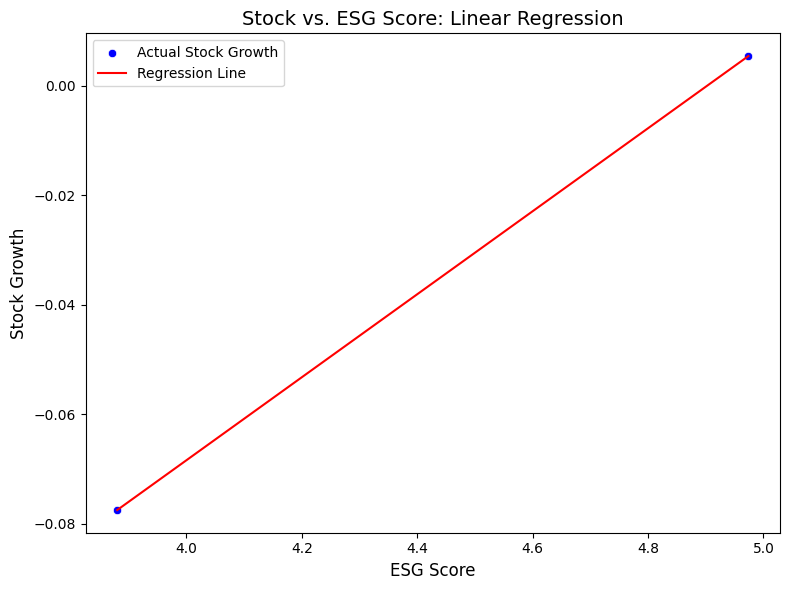

In [71]:
X_esg = X['overall_esg_score']

# Assuming 'X' is ESG score and 'y_stock' is Stock Growth from your model
# Get the predicted Stock Growth values from the model
y_stock_pred = model_stock.predict(X)

# Create a scatter plot of ESG score vs. actual Stock Growth
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_esg, y=y_stock, color='blue', label='Actual Stock Growth')

# Plot the regression line (fit)
sns.lineplot(x=X_esg, y=y_stock_pred, color='red', label='Regression Line')

# Title and labels
plt.title('Stock vs. ESG Score: Linear Regression', fontsize=14)
plt.xlabel('ESG Score', fontsize=12)
plt.ylabel('Stock Growth', fontsize=12)

# Show the plot
plt.legend()
plt.tight_layout()
plt.show()